# <center>Network Science</center>

## <center/>Course Project #3

### <center>Student: Kireev Ruslan</center>

#### <hr /> General Information

**Hard Deadline:** 17.06.2015 23:59 <br \>

Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2016] *{LastName}* *{First Name}* Project*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

# Description

## Task 1 

You are provided with the [DBLP dataset](https://www.hse.ru/data/2016/05/17/1128901387/dblp.zip) or [HSE Dataset](https://drive.google.com/folderview?id=0BwBztFAl6eLOdGRhbW5DWElQY3c&usp=sharing) (warning, raw data!). It contains coauthorships that were revealed during $2000$-$2014$. Particularly, the file contains $3$ colomns: first two for authors' names and the third for the year of publication. This data can be naturally mapped to undirected graph structure.

Your task is construct supervised link prediction scheme.

### Guidelines:

0. Use *pandas* module to load and manipulate the dataset in Python
1. Initiallize your classification set as follows:
    * Determine training and testing intervals on your time domain (for instance, in DBLP dataset take a period $2000$-$2010$ as training period and $2011$-$2014$ as testing period)
    * Pick pairs of authors that **have appeared during training interval** but **have not published together** (only for DBLP) during it
    * These pairs form **positive** or **negative** examples depending on whether they have formed coauthorships **during the testing interval**
    * You have arrived to binary classification problem. PROFIT!
2. Construct feature space:
    * Most of our features tend to be topological. Examples of the features can be: (weighted) sum of neigbours, shortest distance, etc
3. Choose at least $4$ classification algorithms from [scikit module](http://scikit-learn.org/stable/) (goes with Anaconda) and compare them in terms of Accuracy, Precision, Recall, F-Score (for positive class) and Mean Squared Error. Use k-fold cross-validation and average your results

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import gc
%matplotlib inline

In [9]:
df = pd.read_csv('dblp_2000.csv', header=None)
df.columns = ['author1', 'author2', 'year']
df_train = df.loc[df['year'].isin(range(2000, 2009))] # 3940951 edges
df_test = df.loc[df['year'].isin(range(2009, 2015))] # 5655908 edges
print len(df_train), len(df_test)
del df_train['year']
del df_test['year']
authors = pd.concat([df_train['author1'], df_train['author2']]).unique() #  authors that have appeared during training interval
df_test_pairs = df_test.loc[df_test['author1'].isin(authors)].loc[df_test['author2'].isin(authors)] # we consider only "old" 
                                                                                                    # authors in the test interval

3940951 5655908


In [12]:
# we want to drop all occurances of training edges in the test set
a1 = df_test_pairs['author1']  # since in the dataset there can appear both (a1, a2) and (a2, a1)
a2 = df_test_pairs['author2']  # we construct the new df, where all edges are reversed
df_test_pairs_swap = pd.DataFrame({'author1' : [], 'author2' : []})
df_test_pairs_swap['author1'] = a2
df_test_pairs_swap['author2'] = a1
df_intersection1 = pd.merge(df_test_pairs, df_train, how='inner', on=['author1', 'author2']).drop_duplicates()
df_intersection2 = pd.merge(df_test_pairs_swap, df_train, how='inner', on=['author1', 'author2']).drop_duplicates()
df_intersection = pd.concat([df_intersection1, df_intersection2])
set_intersection = set([])
for row in df_intersection.iterrows():
    set_intersection.add((row[1][0], row[1][1]))
idxs = []
for row in df_test_pairs.iterrows(): # find all occurances of training edges
    if ((row[1][0], row[1][1]) in set_intersection) or ((row[1][1], row[1][0]) in set_intersection): # double check!
        idxs.append(row[0])
df_pos = df_test_pairs.drop(idxs) # and drop them and now we have our positive examples

So, now we have to construct our negative examples. Since there are to many such pairs (about 2.3*10^11), it will cost too much time to consider all of them. Therefore, we randomly pick len(df_pos) among them. At least, it seems reasonable.

In [13]:
(len(authors)*(len(authors)-1))/2.0-len(df_train)

224749336427.0

In [14]:
df_dd = df.drop_duplicates() 
set_dd = set([]) # is what won't appear in negative examples. also we don't want, if there is pos&neg!=empty
for row in df_dd.iterrows():
    set_dd.add((row[1][0], row[1][1]))

In [16]:
d_neg = {'author1':[], 'author2':[]}
count = 0
l = len(authors) - 1
n = len(df_pos) # there will be about len(df_pos) negative examples
while(count < n): 
    r = [0]*2
    while r[0] == r[1]:
        r = np.random.random_integers(0, l, 2)
    a0 = authors[r[0]]
    a1 = authors[r[1]]
    rand_pair1 = (a0, a1)
    rand_pair2 = (a1, a0)
    if not((rand_pair1 in set_dd) and (rand_pair2 in set_dd)): # (a1, a2) <=> (a2, a1)
        d_neg['author1'].append(a0)
        d_neg['author2'].append(a1)
        count += 1
gc.collect()

0

In [21]:
df_neg = pd.DataFrame.from_dict(d_neg).drop_duplicates()
df_neg['label'] = pd.Series([-1]*len(df_neg), index=df_neg.index)
df_pos['label'] = pd.Series([1]*len(df_pos), index=df_pos.index)
df_posneg = pd.concat([df_pos, df_neg]) # here is our labeled sample

In [16]:
# maybe it will help to free my RAM a bit, idk
del df_intersection
del set_intersection
del idxs
del d_neg
del set_dd
del df_dd
gc.collect()

281

In [33]:
# to be able to predict something we have to know what properties had the edges in the training interval
# to calculate everything we put the train set in a graph 
# (multigraph is more appropriate since there are multiedges, but I couldn't do that, probably, due to some hardware capabilities)
G = nx.Graph()
nx.from_pandas_dataframe(df_train, 'author1', 'author2', create_using=G)

Basically, I followed the articles ["Link Prediction using Supervised Learning"](http://www.siam.org/meetings/sdm06/workproceed/Link%20Analysis/12.pdf) and ["Feature Engineering for Supervised Link Prediction on Dynamic Social Networks"](http://worldcomp-proceedings.com/proc/p2014/DMI8018.pdf)
To be hosest, we pick from a wide variety of feature those, which are easy and quick to compute: Number of common neighbors, Jaccard’s coefficient, Adamic/Adar, Shortest path, Preferential attachment, Clustering coefficient.

In [40]:
shortest_paths = []
common_neighbor = []
jaccard_coef = []
preferential_attachment = []
clustering_coef_u = []
clustering_coef_v = []
adar = []
for row in df_posneg.iterrows(): # for each example in pos+neg  
    try:
        shortest_paths.append(nx.shortest_path_length(G,source=row[1][0],target=row[1][1]))
    except:
        shortest_paths.append(10000) # 10000 = infinity
    N1 = set(G.neighbors(row[1][0]))
    N2 = set(G.neighbors(row[1][1]))
    common_neighbor.append(len(N1 & N2))
    jaccard_coef.append(1.0*len(N1 & N2)/len(N1 | N2))
    preferential_attachment.append(len(N1)*len(N2))
    clustering_coef_u.append(nx.clustering(G,row[1][0]))
    clustering_coef_v.append(nx.clustering(G,row[1][1]))
    aa = 0
    for node in N1 & N2:
        aa += 1.0/np.log(G.degree(node))
    adar.append(aa)

df_posneg['shortest_path'] = pd.Series(shortest_paths, index=df_posneg.index)
df_posneg['common_neighbors'] = pd.Series(common_neighbor, index=df_posneg.index)
df_posneg['jaccard'] = pd.Series(jaccard_coef, index=df_posneg.index)
df_posneg['preferential_attachment'] = pd.Series(preferential_attachment, index=df_posneg.index)
df_posneg['clustering_u'] = pd.Series(clustering_coef_u, index=df_posneg.index)
df_posneg['clustering_v'] = pd.Series(clustering_coef_v, index=df_posneg.index)
df_posneg['adamic-adar'] = pd.Series(adar, index=df_posneg.index)
df_posneg.to_csv('dfdfdfdf') # save the df for future
del shortest_paths
del common_neighbor
del jaccard_coef
del preferential_attachment
del clustering_coef_u
del clustering_coef_v
gc.collect()

In [3]:
#df_posneg = pd.read_csv('dfdfdf') # I used previously saved df, in order to not compute everything again
#del df_posneg['Unnamed: 0']       

In [4]:
y = df_posneg['label']
X = df_posneg
del X['author1']
del X['author2']
del X['label']

In [99]:
def stat_feature(feature, border, plot=1, bins=10): # returns mean and std of features and draws the plot 
    pos = feature[:border] # border is approximately in the middle, since len(pos)~len(neg)
    neg = feature[border:]
    try:
        if len(feature.loc[feature==10000]) > 0: # we do not count infinity here
            pos = pos.loc[pos!=10000]
            neg = neg.loc[neg!=10000]
    except:
        pass
    print 'Positive mean: ', np.mean(pos)
    print 'Positive std: ', np.std(pos)
    print 'Negative mean: ', np.mean(neg)
    print 'Negative std: ', np.std(neg)
    if plot:
        hist_pos, bin_edges = np.histogram(pos, bins=bins)
        plt.plot(hist_pos, label='positive')
        hist_neg, bin_edges = np.histogram(neg, bins=bins)
        plt.plot(hist_neg, label='negative')
        plt.ylabel('count')
        plt.xlabel('bins')
        plt.legend(loc=2, fontsize=9)
        plt.show()
    else:
        hist_pos, bin_edges = np.histogram(pos, bins=bins)
        plt.loglog(hist_pos, label='positive')
        hist_neg, bin_edges = np.histogram(neg, bins=bins)
        plt.loglog(hist_neg, label='negative')
        plt.ylabel('count')
        plt.xlabel('bins')
        plt.legend(loc=2, fontsize=9)
        plt.show()

Positive mean:  0.38692803635
Positive std:  0.340635902213
Negative mean:  0.642481603593
Negative std:  0.399054361707


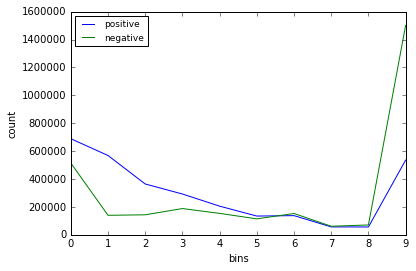

In [100]:
stat_feature(zip(X['clustering_u'], X['clustering_v']), len(X)/2)

Positive mean:  4.04447288356
Positive std:  1.60860042831
Negative mean:  6.66572780063
Negative std:  1.37109018828


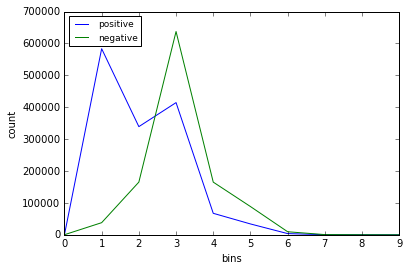

In [101]:
stat_feature(X['shortest_path'], len(X)/2) 

Positive mean:  0.0131769251842
Positive std:  0.0501742117857
Negative mean:  1.15607324564e-05
Negative std:  0.00168943321022


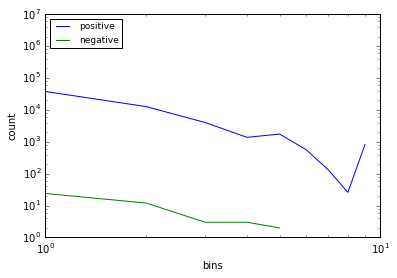

In [102]:
stat_feature(X['jaccard'], len(X)/2, plot=0) # loglog scale

Positive mean:  0.363224305032
Positive std:  1.38950595518
Negative mean:  0.000318542182488
Negative std:  0.103160570295


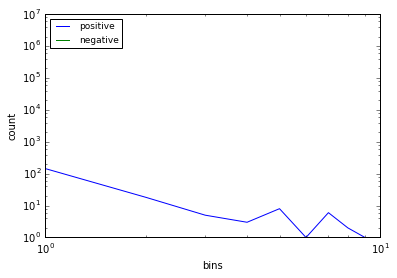

In [104]:
stat_feature(X['common_neighbors'], len(X)/2, plot=0) # loglog scale

Positive mean:  956.032660682
Positive std:  3629.75487008
Negative mean:  47.1552682533
Negative std:  160.387826338


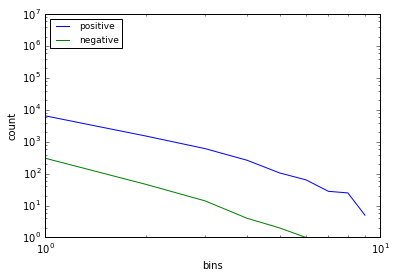

In [105]:
stat_feature(X['preferential_attachment'], len(X)/2, plot=0) # loglog scale

As we can see from the pictures, there are a quite different curves of the same feature for positive and negative classes.

Now we implement several classifiers popular in the binary classification task. We chosed Random Forest, Logistic Regression, Gaussian Naive Bayes and Decision Tree.

In [17]:
X = (X - X.mean()) / (X.std())

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [19]:
results = {'Classifier':['Random Forest', 'Logistic', 'Naive Bayes', 'Decision Tree'], 
           'Accuracy':[], 'Precision':[], 'Recall':[], 'F-score':[], 'MSE':[]}
for clf in [RandomForestClassifier(), LogisticRegression(), GaussianNB(), DecisionTreeClassifier()]:
    kf = cross_validation.KFold(len(X), n_folds=5, shuffle=True) 
    precision = []
    recall = []
    f_score = []
    accuracy = []
    mse = []
    for train_index, test_index in kf:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        recall.append(metrics.recall_score(y_test, y_pred, average='binary'))
        precision.append(metrics.precision_score(y_test, y_pred, average='binary'))
        f_score.append(metrics.f1_score(y_test, y_pred, average='binary'))
        mse.append(metrics.mean_squared_error(y_test, y_pred))
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
    results['Precision'].append(np.mean(precision))
    results['Recall'].append(np.mean(recall))
    results['F-score'].append(np.mean(f_score))
    results['Accuracy'].append(np.mean(accuracy))
    results['MSE'].append(np.mean(mse))
df_results = pd.DataFrame.from_dict(results)

In [20]:
df_results # note, that mse is larger, because we have the labels {-1, 1} instead of {0, 1}

,Accuracy,Classifier,F-score,MSE,Precision,Recall
0,0.850840,Random Forest,0.841703,0.596639,0.876097,0.809908
1,0.791420,Logistic,0.769653,0.834321,0.837915,0.711677
2,0.686664,Naive Bayes,0.534097,1.253342,0.981945,0.366815
3,0.844056,Decision Tree,0.832909,0.623775,0.876076,0.793797


The results shown in the table almost agrees with the result from the first article.  Almost the same values showed Random Forest and Decision Tree. Naive Bayes performed pourly. 

Note: there wasn't any tuning performed, it computes to long, besides, the first article says that using default paremeter values is fine.

## Task 2

Consider the [flickr dataset](https://www.hse.ru/data/2016/05/17/1128901463/flickr_data.tar.gz) (warning, raw data!). <br/>
File ''*users.txt*'' provides a table of form *userID*, *enterTimeStamp*, *additionalInfo*... <br/>
File "*contacts.txt*" consists of pairs of *userID*'s and link establishment timestamp <br/>

Recall *scoring functions* for link prediction. Your task is to compare the performance of each scoring function as follows:
1. TOP-$n$ accuracy
    * Denote the number of links $E_\text{new}$ appeared during testing period as $n$
    * Denote the ranked list of node pairs provided by score $s$ as $\hat{E}_s$
    * Take top-$n$ pairs from $\hat{E}_s$ and intersect it with $E_\text{new}$. Performance is measured as the size of resulted set
2. ROC and AUC ('star' subtask)

Essentially, for this task you also have to follow the guideline points $1$ and $2$ above. The only thing you have to keep in mind is that flickr dataset is growing dataset. Since then, consider nodes that are significantly represented both in training and testing intervals (for instance, have at least $5$ adjacent edges in training and testing intervals)

In [2]:
df = pd.read_csv('contacts.txt', header=None, sep=' ')
df.columns = ['user1', 'user2', 'time']
df = df.drop(df['time'].loc[df['time']<0].keys()) # drop negative values
df_train = df.loc[df['time']>np.mean(df['time'])]  # mean gives about 2/3 1/3 split
df_test = df.loc[df['time']<=np.mean(df['time'])]
print len(df_train), len(df_test)
del df_train['time']
del df_test['time']
hist = df_train.stack().value_counts()
valid_nodes = hist[hist>6].keys() # leave only nodes with degree>6
df_train = df_train.loc[df_train['user1'].isin(valid_nodes)].loc[df_train['user2'].isin(valid_nodes)]
hist = df_test.stack().value_counts()
valid_nodes = hist[hist>6].keys()
df_test = df_test.loc[df_test['user1'].isin(valid_nodes)].loc[df_test['user2'].isin(valid_nodes)] 

2769405 1872279


In [3]:
nodes_in_train = pd.concat([df_train['user1'], df_train['user2']]).unique() # nodes appeared in train
nodes_in_test = pd.concat([df_test['user1'], df_test['user2']]).unique() # nodes appeared in test
core = np.intersect1d(nodes_in_test, nodes_in_train) # nodes appeared in train and test (core set)
df_test_pairs = df_test.loc[df_test['user1'].isin(core)].loc[df_test['user2'].isin(core)]
df_intersection = pd.merge(df_test_pairs, df_train, how='inner', on=['user1', 'user2']).drop_duplicates() # is empty
df_pos = df_test_pairs # E_new w to be the set of edges such that the two nodes appeared together in the test, but not in
                       # the train

Again, there are to many edges that do not exist in the test period. And we cannot check all of them, that's why we will check 10000000 of them

In [83]:
set_dd = set([])
for row in df_train.iterrows():
    set_dd.add((row[1][0], row[1][1]))
    set_dd.add((row[1][1], row[1][0]))

In [112]:
d_unknown = {'user1':[], 'user2':[]}
count = 0
l = len(core) - 1 # from core x core. we can't predict edges with new nodes
while(count < 10000000): 
    r = [0]*2
    while r[0] == r[1]:
        r = np.random.random_integers(0, l, 2)
    a0 = core[r[0]]
    a1 = core[r[1]]
    rand_pair = (a0, a1)
    if not (rand_pair in set_dd):
        d_unknown['user1'].append(a0)
        d_unknown['user2'].append(a1)
        count += 1
gc.collect()
df_unknown = pd.DataFrame.from_dict(d_unknown).drop_duplicates() # 10000000 randomly picked edges from (core x (core-1)) - train

In [86]:
G = nx.Graph()
nx.from_pandas_dataframe(df_train, 'user1', 'user2', create_using=G)

Scoring functions are same as before, except clustering 

In [113]:
shortest_paths = []
common_neighbor = []
jaccard_coef = []
preferential_attachment = []
adar = []
for row in df_unknown.iterrows():     
    try:
        shortest_paths.append(1.0/nx.shortest_path_length(G,source=row[1][0],target=row[1][1]))
    except:
        shortest_paths.append(1.0/10000)
    N1 = set(G.neighbors(row[1][0]))
    N2 = set(G.neighbors(row[1][1]))
    common_neighbor.append(len(N1 & N2))
    jaccard_coef.append(1.0*len(N1 & N2)/len(N1 | N2))
    preferential_attachment.append(len(N1)*len(N2))
    aa = 0
    for node in N1 & N2:
        aa += 1.0/np.log(G.degree(node))
    adar.append(aa)
df_unknown['shortest_path'] = pd.Series(shortest_paths, index=df_unknown.index)
df_unknown['common_neighbors'] = pd.Series(common_neighbor, index=df_unknown.index)
df_unknown['jaccard'] = pd.Series(jaccard_coef, index=df_unknown.index)
df_unknown['preferential_attachment'] = pd.Series(preferential_attachment, index=df_unknown.index)
df_unknown['adamic-adar'] = pd.Series(adar, index=df_unknown.index)
df_unknown.to_csv('df_flickr')
del shortest_paths
del common_neighbor
del jaccard_coef
del preferential_attachment
del adar
gc.collect()

28

In [2]:
#df_unknown = pd.read_csv('df_flickr')
#del df_unknown['Unnamed: 0']

In [3]:
df_unknown

,user1,user2,shortest_path,common_neighbors,jaccard,preferential_attachment,adamic-adar
0,200363,721751,0.250000,0,0.000000,57,0.000000
1,590873,593108,0.333333,0,0.000000,42,0.000000
2,276545,608044,0.166667,0,0.000000,18,0.000000
3,378420,16574,0.500000,3,0.050000,986,0.410166
4,182377,370779,0.333333,0,0.000000,8704,0.000000
5,439300,86069,0.200000,0,0.000000,72,0.000000
6,317659,353218,0.250000,0,0.000000,47,0.000000
7,576537,87386,0.333333,0,0.000000,170,0.000000
8,353733,357832,0.200000,0,0.000000,24,0.000000
9,512265,624323,0.333333,0,0.000000,7595,0.000000


In [5]:
# what edges in the generated set appear in test?
df_pos_in_unknown = pd.merge(df_pos, df_unknown, how='inner', on=['user1', 'user2']).drop_duplicates() 
set_intersection = set([])
for row in df_pos_in_unknown.iterrows():
    set_intersection.add((row[1][0], row[1][1]))

In [6]:
# here we separate positive and negative among df_unknown
idxs = []
for row in df_unknown.iterrows():
    if ((row[1][0], row[1][1]) in set_intersection) or ((row[1][1], row[1][0]) in set_intersection):
        idxs.append(row[0])
df_neg_in_unknown = df_unknown.drop(idxs)
n = len(df_pos_in_unknown)
n_neg = len(df_neg_in_unknown)
df_neg_in_unknown.to_csv('df_neg_in_unknown')
df_pos_in_unknown.to_csv('df_pos_in_unknown')

In [3]:
#df_neg_in_unknown = pd.read_csv('df_neg_in_unknown')
#del df_neg_in_unknown['Unnamed: 0']
#df_pos_in_unknown = pd.read_csv('df_pos_in_unknown')
#del df_pos_in_unknown['Unnamed: 0']


Since we generated only 10000000 pairs, we must consider only those positive edges, which are in these 10000000 pairs.
So, n = len(df_pos_in_unknown). Therefore, the number of negative is 10000000-n.

We take best n among 10000000 pairs using each scoring function:

In [27]:
for scoring in ['preferential_attachment', 'shortest_path', 'common_neighbors', 'jaccard', 'adamic-adar']:
    top = df_unknown.sort_values(scoring, ascending=False)[:n]
    prob = 1.0*len(pd.merge(df_pos_in_unknown, top, how='inner', on=['user1', 'user2']).drop_duplicates())/n
    print scoring, ': ', prob

preferential_attachment :  0.0963012083702
shortest_path :  0.00935750073681
common_neighbors :  0.133289124668
jaccard :  0.109858532272
adamic-adar :  0.136973180077


These numbers allow us to compare perfomance of the scoring functions. So, the best result demonstrated Adamic-Adar, slightly worse are common neighbors and Jaccard's coefficient. Preferential attachment is also quite good, in contrast with the [article](http://www.cs.rpi.edu/~magdon/courses/casp/projects/BhardwajLu.pdf). The shortest path score should perform much better, but the problem is that the edges with the smallest distance of 2 are more then $n$. It show much better result with ROC-curve 

Compare with the random guess:

In [34]:
top = df_unknown.sample(n)
prob = 1.0*len(pd.merge(df_pos_in_unknown, top, how='inner', on=['user1', 'user2']).drop_duplicates())/n
print 'random: ', prob

random:  0.00132625994695


In [5]:
def FPRTPR(top_k, df_pos_in_unknown, df_neg_in_unknown, np, nn): # returns TPR and FPR
    TPR = 1.0*len(pd.merge(df_pos_in_unknown, top_k, how='inner', on=['user1', 'user2']).drop_duplicates())/np
    FPR = 1.0*len(pd.merge(df_neg_in_unknown, top_k, how='inner', on=['user1', 'user2']).drop_duplicates())/nn
    return TPR, FPR

Here we move the margin between pos and neg (the number of top nodes $k$) classes along each scoring function. 

Calculate ROC-curve, when we are so random:

0.0 0.0
0.202917771883 0.199995563617
0.395225464191 0.400006251267
0.599395814913 0.600001109096
0.802387267905 0.799996370232
1.0 0.999999596692


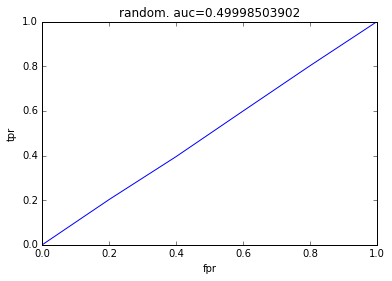

In [8]:
np = len(df_pos_in_unknown)
nn = len(df_neg_in_unknown)
fpr, tpr = [], []
auc = 0
for k in range(0, len(df_unknown),len(df_unknown)/5):
    top = df_unknown.sample(k)
    x, y = FPRTPR(top, df_pos_in_unknown, df_neg_in_unknown, np, nn)
    fpr.append(y)
    tpr.append(x)
    print x, y
for ind in range(1, len(fpr)):
    auc += (fpr[ind]-fpr[ind-1])*(tpr[ind-1]+tpr[ind])/2 # auc calculation
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('random. auc='+str(auc))
plt.show()

Scoring functions:

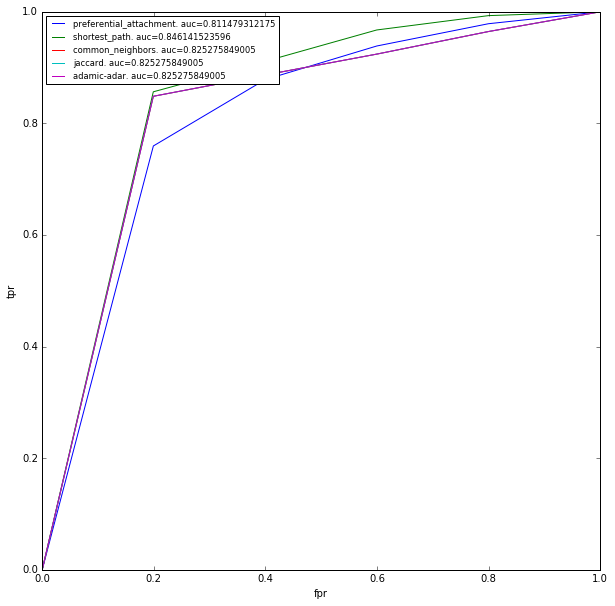

In [14]:
plt.figure(figsize=(10,10))
for scoring in ['preferential_attachment', 'shortest_path', 'common_neighbors', 'jaccard', 'adamic-adar']:
    fpr, tpr = [], []
    auc = 0
    top = df_unknown.sort_values(scoring, ascending=False)
    for k in range(0, len(df_unknown),len(df_unknown)/5): # 5 is to compute quickier
        x, y = FPRTPR(top[:k], df_pos_in_unknown, df_neg_in_unknown, np, nn)
        fpr.append(y)
        tpr.append(x)
    for ind in range(1, len(fpr)):
        auc += (fpr[ind]-fpr[ind-1])*(tpr[ind-1]+tpr[ind])/2
    plt.plot(fpr, tpr, label = scoring+'. auc='+str(auc))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(fontsize='small', loc=2)
plt.show()

The shortest path distance achieved the highest score among the other predictors. 